<div style="text-align:center;">
    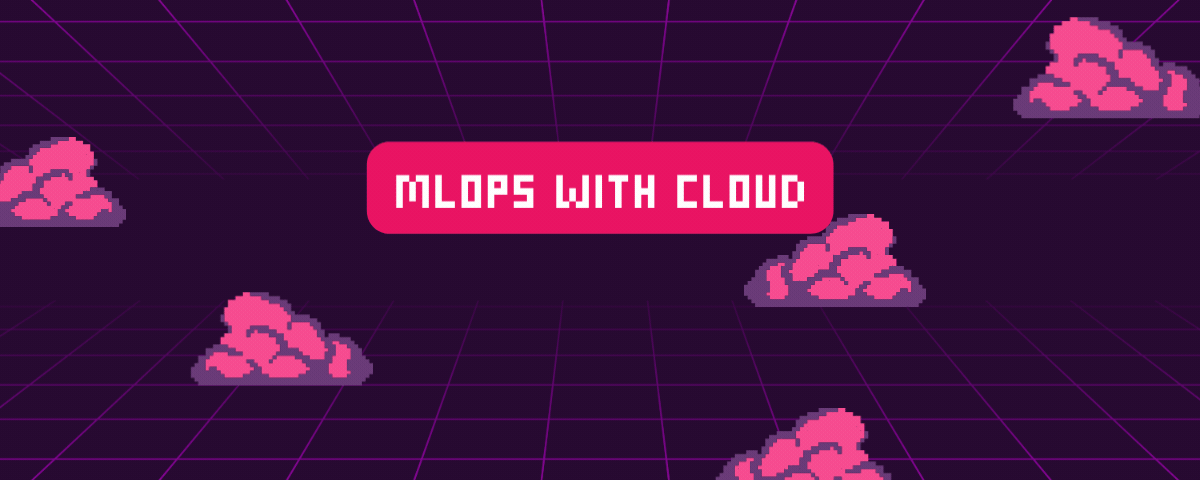
</div>

# Loading the features from feature store for tranining
(( Explain the importance of feature store, data versioning etc etc )) \
Instruct to find the latest version of the dataset from the feature store S3 bucket

Go the S3 bucket which is being used as the feature store,
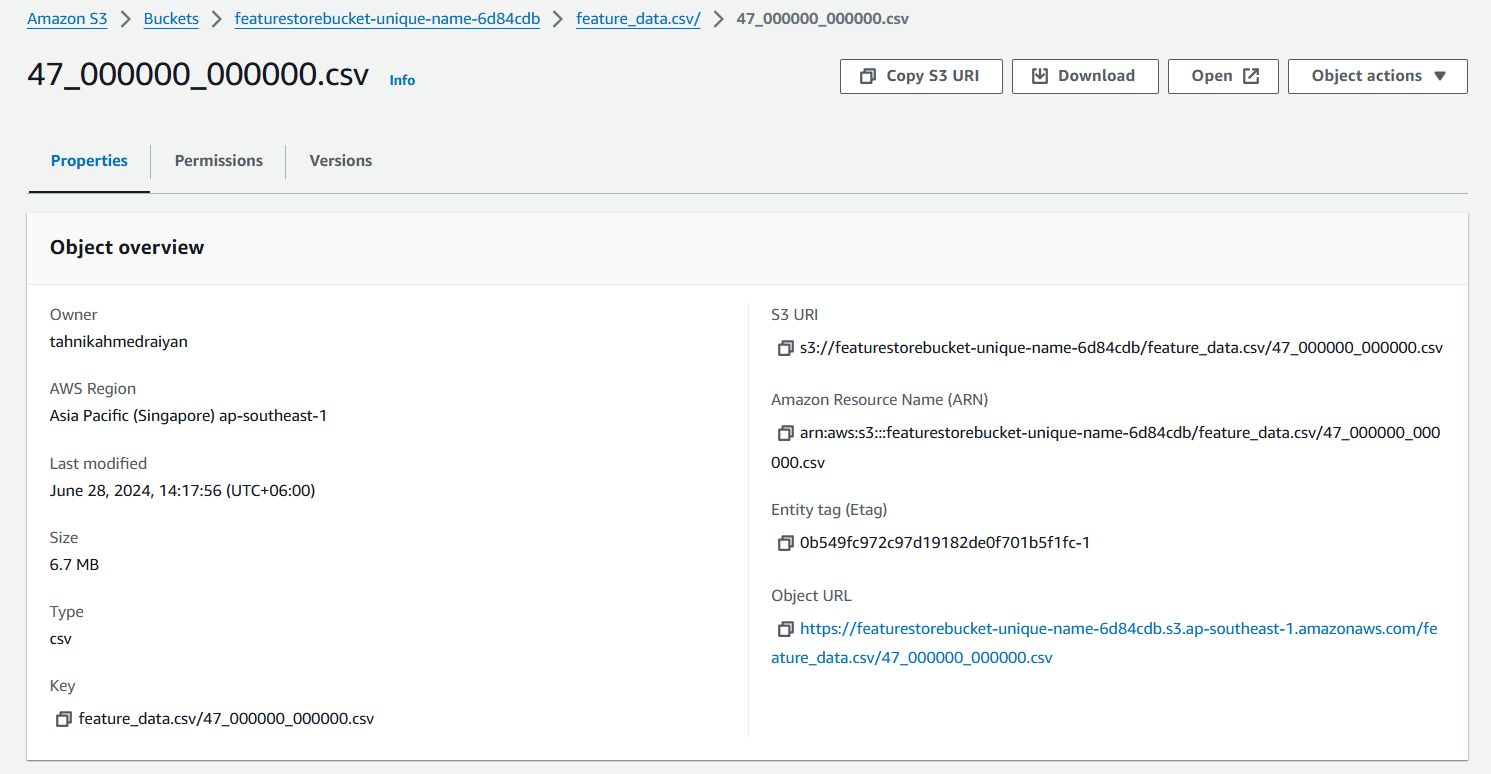

Find the latest version of the dataset,
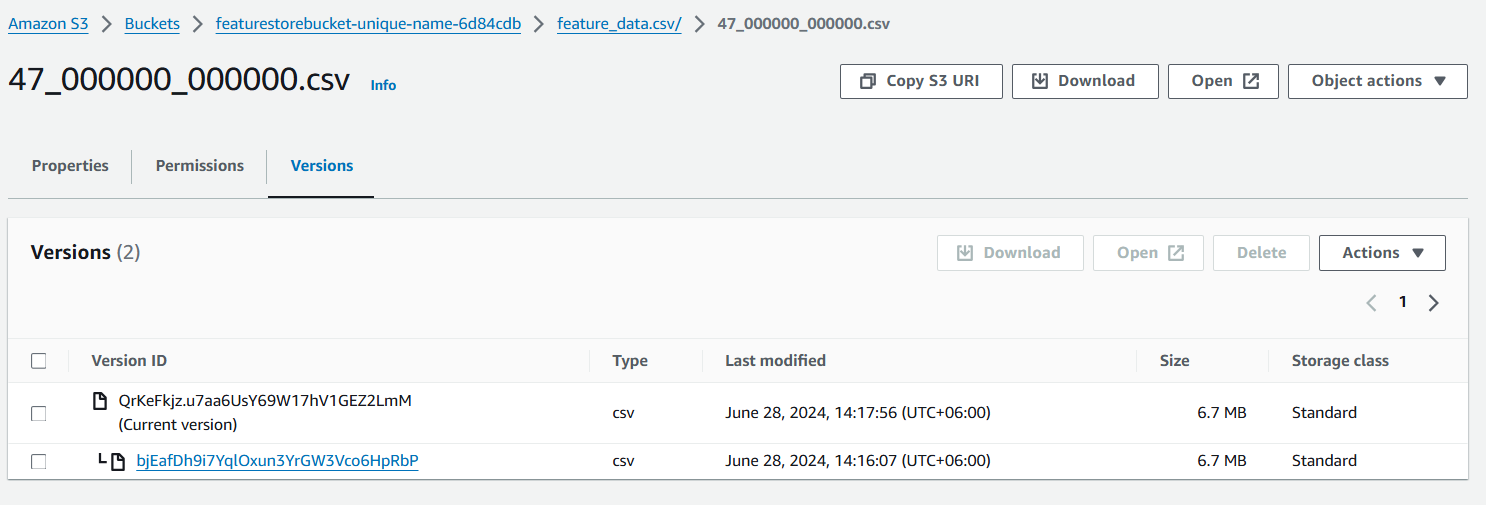


Go to the dataset's latest version and observe it,
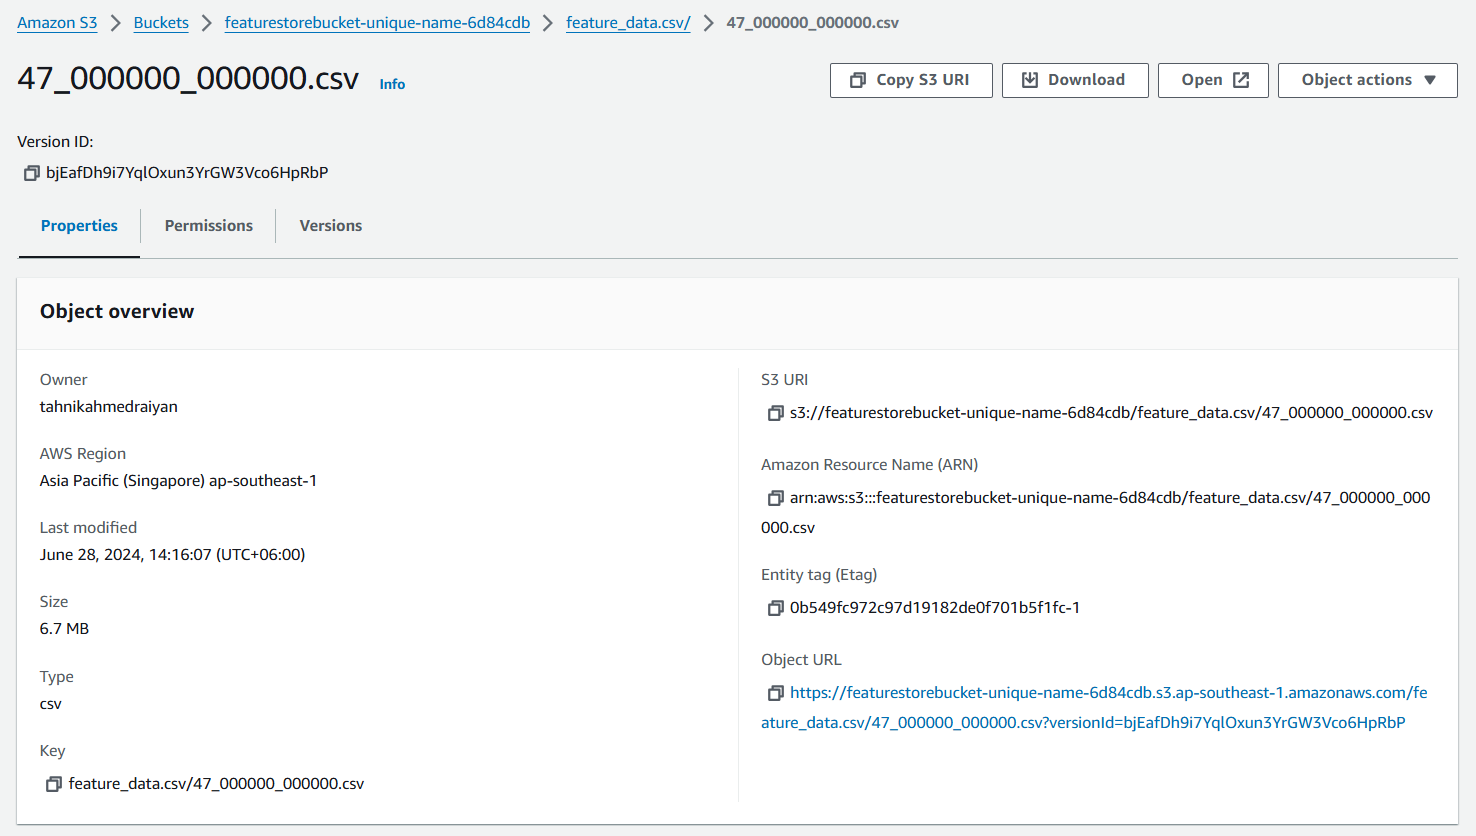

***Specify your S3 bucket, key (file path), and version ID:***

for example, here is the URI of the latest version of the dataset that was trained earlier (your URI will be obviously different),

** " https:// featurestorebucket-unique-name-6d84cdb.s3.ap-southeast-1.amazonaws .com/feature_data.csv/22_000000_000000.csv?versionId=K3UdMzswW8pjhYAOkpbJS1eCZ8xyv6PE " **

In [1]:
import boto3
import ray
import pandas as pd
s3_client = boto3.client('s3')

# Specify your S3 bucket, key (file path), and version ID
bucket_name = ""
file_key = ""
version_id = ""

In [2]:
s3_client

### Download the specific version of the features to the local file system

In [3]:
local_file_path = "3-training-data/training_features.csv"
s3_client.download_file(bucket_name, file_key, local_file_path, ExtraArgs={"VersionId": version_id})

# Importing the Features to Ray Datasets

In [4]:
df_lagged = pd.read_csv(local_file_path)

In [5]:
df_lagged.head()

,Year,Month,Day,Hour,Temperature_mean,Humidity_mean,WindSpeed_mean,GeneralDiffuseFlows_mean,DiffuseFlows_mean,PowerConsumption_Zone1_sum,...,PowerConsumption_Zone2_sum_lag4,PowerConsumption_Zone2_sum_lag8,PowerConsumption_Zone2_sum_lag12,PowerConsumption_Zone2_sum_lag24,PowerConsumption_Zone2_sum_lag48,PowerConsumption_Zone3_sum_lag4,PowerConsumption_Zone3_sum_lag8,PowerConsumption_Zone3_sum_lag12,PowerConsumption_Zone3_sum_lag24,PowerConsumption_Zone3_sum_lag48
0,2017,1,1,0,0.166667,0.723684,0.0,0.0,0.0,0.472844,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,2017,1,1,1,0.125000,0.765789,0.0,0.0,0.0,0.328443,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,2017,1,1,2,0.093750,0.784211,0.0,0.0,0.0,0.246585,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,2017,1,1,3,0.104167,0.755263,0.0,0.0,0.0,0.206128,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,2017,1,1,4,0.104167,0.710526,0.0,0.0,0.0,0.195475,...,0.609856,0.0,0.0,0.0,0.0,0.69688,0.0,0.0,0.0,0.0


In [6]:
type(df_lagged)

pandas.core.frame.DataFrame

# Distributed Training with Ray Train
((( Discuss how ray distributes the training workload)) Give an explanation about the Ray train processes,
Certainly! **Ray Train** is a scalable machine learning library designed for distributed training and fine-tuning. Here are the key points about Ray Train:

1. **Scalability**: Ray Train allows you to scale your model training code from a single machine to a cluster of machines in the cloud. It abstracts away the complexities of distributed computing, making it easier to handle large models or datasets.

2. **Frameworks Supported**:
   - Ray Train provides support for various frameworks, including:
     - **PyTorch**
     - **TensorFlow**
     - **PyTorch Lightning**
     - **Keras**
     - **Hugging Face Transformers**
     - **Horovod**
     - **XGBoost**
     - **DeepSpeed**
     - **LightGBM**

3. **Components**:
   - **Ray Core**: Includes components like tasks, actors, objects, and placement groups.
   - **Ray Data**: A scalable data processing library for ML workloads.
   - **Ray Train**: Specifically focused on distributed training and fine-tuning¹.

4. **Getting Started**:
   - To use Ray Train, you'll define a Python function (`train_func`) that executes on each distributed training worker.
   - You'll configure the number of workers and whether to use GPUs using `ScalingConfig`.
   - Finally, you'll launch the distributed training job using `TorchTrainer`².

Here's the basic architecture of the components of Ray Train. We'll dive deeper about the components and complex workflows in the dedicated modules of Ray in the course.


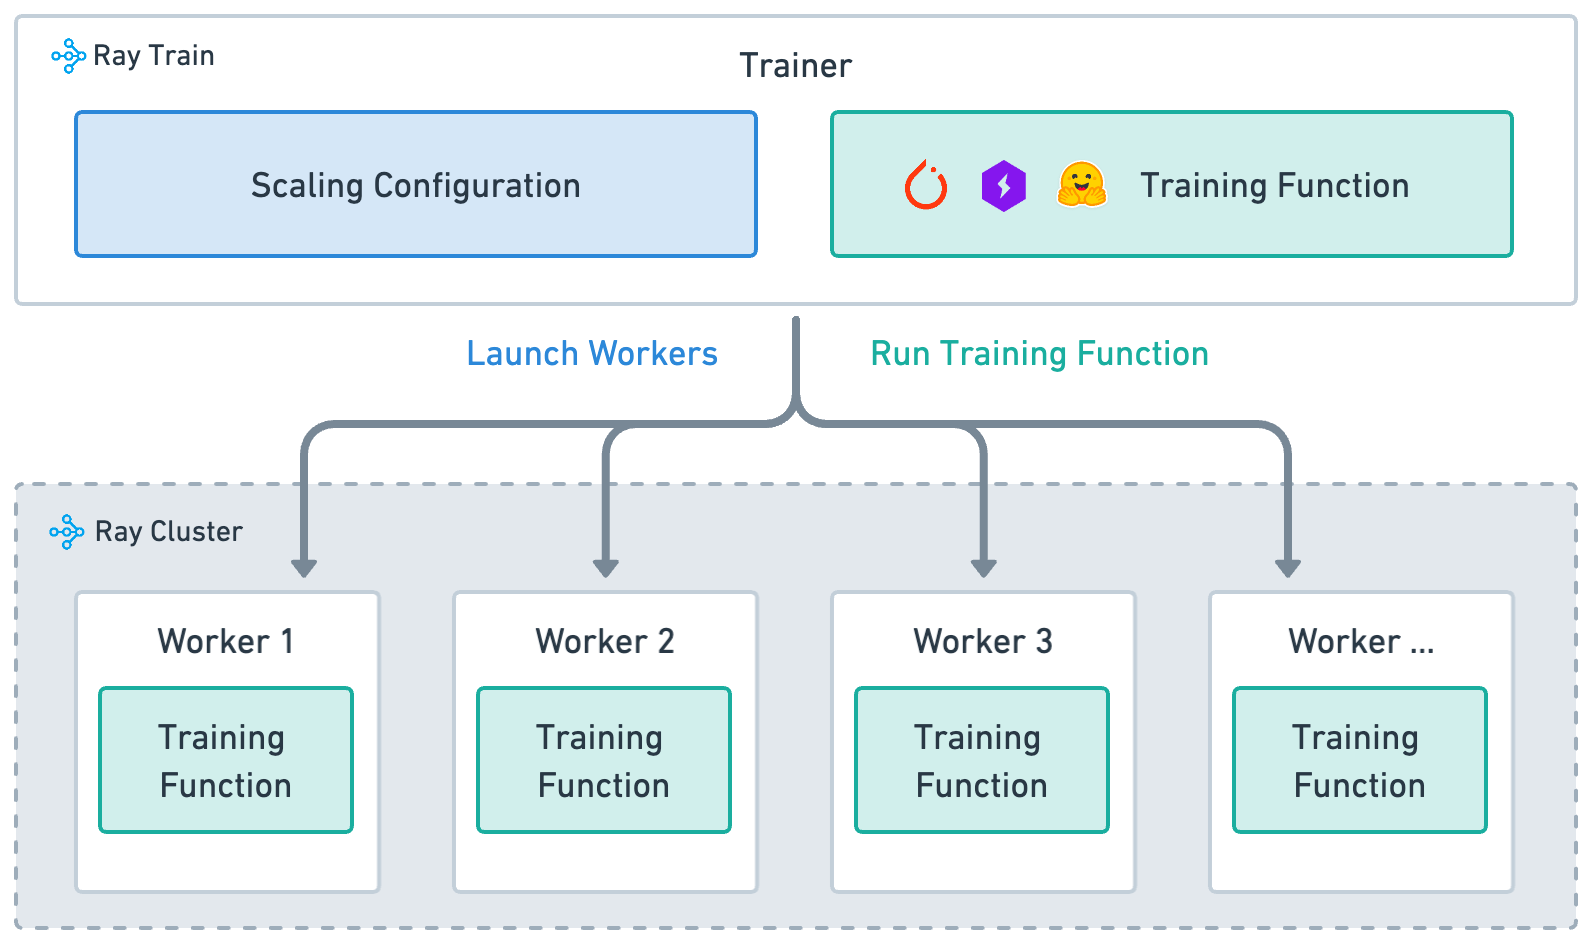

## Setting up the function for visualizing predictions

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_predictions(y_test, y_pred):
    """
    Visualizes the actual vs predicted values using a scatter plot and a line plot.

    Parameters:
    - y_test: The actual values.
    - y_pred: The predicted values.
    """
    # Convert to DataFrame
    df_visualization = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_visualization['Actual'], df_visualization['Predicted'], alpha=0.5)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

    # Line plot for comparison
    plt.figure(figsize=(10, 6))
    plt.plot(df_visualization['Actual'].reset_index(drop=True), label='Actual Values', marker='o')
    plt.plot(df_visualization['Predicted'].reset_index(drop=True), label='Predicted Values', linestyle='--', marker='x')
    plt.title('Actual vs Predicted Values Comparison')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (assuming you have y_test and y_pred available)
# visualize_predictions(y_test, y_pred)

# Training the Model with XGBoost + Ray Train
In this training workflow, we're going to use XGBoost to train the model with the features we have computed in the previous notebook. \
You are going to use MLFlow to track the traiing experiments. \
Follow the Instructions in the lab prompt to set up MLFlow server in your head node.

In [9]:
!pip install mlflow


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd  # Assuming df_lagged is a pandas DataFrame
from ray import train
from ray.train import ScalingConfig
from ray.train.xgboost import XGBoostTrainer

import os
import tempfile
import time
import mlflow
from ray.air.integrations.mlflow import MLflowLoggerCallback, setup_mlflow

import ray


# Independent variables
X = df_lagged.drop(['PowerConsumption_Zone1_sum', 'PowerConsumption_Zone2_sum', 'PowerConsumption_Zone3_sum'], axis=1)

# Target variable for Zone 1
y1 = df_lagged['PowerConsumption_Zone1_sum']

# Combine X and y1 into a single DataFrame for Ray
df_combined = X.copy()
df_combined['label'] = y1 
# Split the DataFrame
df_train, df_valid = train_test_split(df_combined, test_size=0.2, random_state=42)

# Convert the pandas DataFrames back to Ray datasets
train_dataset = ray.data.from_pandas(df_train)
valid_dataset = ray.data.from_pandas(df_valid)

# Define XGBoost parameters
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": ["rmse", "mae"],
}

# Configuration for the number of workers and compute resources
scaling_config = ScalingConfig(num_workers=2, use_gpu=False)

mlflow_tracking_uri = "http://127.0.0.1:5000"

# Trainer
trainer = XGBoostTrainer(
    scaling_config=scaling_config,
    label_column="label",
    params=xgb_params,
    datasets={"train": train_dataset, "valid": valid_dataset},
    run_config=train.RunConfig(
        storage_path="s3://modelstorebucket-poridhi-12345-f772b84/",
        name="Tranining_Electricity_Consumption",
         callbacks=[
                MLflowLoggerCallback(
                    tracking_uri=mlflow_tracking_uri,
                    experiment_name="mlflow_callback_ray",
                    save_artifact=True,
                )
            ],
    )
)
result = trainer.fit()

2024-09-01 20:02:27,315	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-09-01 20:02:27 (running for 00:00:00.12)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/6 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-09-01_19-54-33_460102_6514/artifacts/2024-09-01_20-02-27/Tranining_Electricity_Consumption/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-09-01 20:02:32 (running for 00:00:05.18)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/6 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-09-01_19-54-33_460102_6514/artifacts/2024-09-01_20-02-27/Tranining_Electricity_Consumption/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-09-01 20:02:37 (running for 00:00:10.25)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/6 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-09-01_19-54-33_460102_6514/artifacts/2024-09-01_20-02-27/Tranining_Electricity_Consumption/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== S

2024/09/01 20:02:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoostTrainer_1cd9c_00000 at: http://127.0.0.1:5000/#/experiments/658919492095784704/runs/632d50ef5984424e8a531366b7cb2978.
2024/09/01 20:02:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/658919492095784704.
2024-09-01 20:02:44,290	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'modelstorebucket-poridhi-12345-f772b84/Tranining_Electricity_Consumption' in 1.0046s.
2024-09-01 20:02:44,306	INFO tune.py:1041 -- Total run time: 16.99 seconds (15.76 seconds for the tuning loop).


== Status ==
Current time: 2024-09-01 20:02:44 (running for 00:00:16.77)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/6 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-09-01_19-54-33_460102_6514/artifacts/2024-09-01_20-02-27/Tranining_Electricity_Consumption/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




## Observe the model training result

In [11]:
result

Result(
  metrics={'train-rmse': np.float64(0.03613293575239122), 'train-mae': np.float64(0.02631559617802475), 'valid-rmse': np.float64(0.04380443473869264), 'valid-mae': np.float64(0.03086805338726232)},
  path='modelstorebucket-poridhi-12345-f772b84/Tranining_Electricity_Consumption/XGBoostTrainer_1cd9c_00000_0_2024-09-01_20-02-27',
  filesystem='s3',
  checkpoint=Checkpoint(filesystem=s3, path=modelstorebucket-poridhi-12345-f772b84/Tranining_Electricity_Consumption/XGBoostTrainer_1cd9c_00000_0_2024-09-01_20-02-27/checkpoint_000000)
)

# Tracking the Model Training Experiment in the MLFlow Server
Go to the MLFlow server running on localhost:9090 and you would your experiment listed in there. Go to the charts section to observe how various model training metrices changes with time and other components or metrics.

In this notebook, we are perforiming a very simple model training experiment. The full utilization of MLFlow lies within complex experiments like large scale hypterparameter optimizations, training on various heterogenous clusters with different model architectures etc. This section is to give you an introduction. We will be working with intensively in the MLFlow labs.



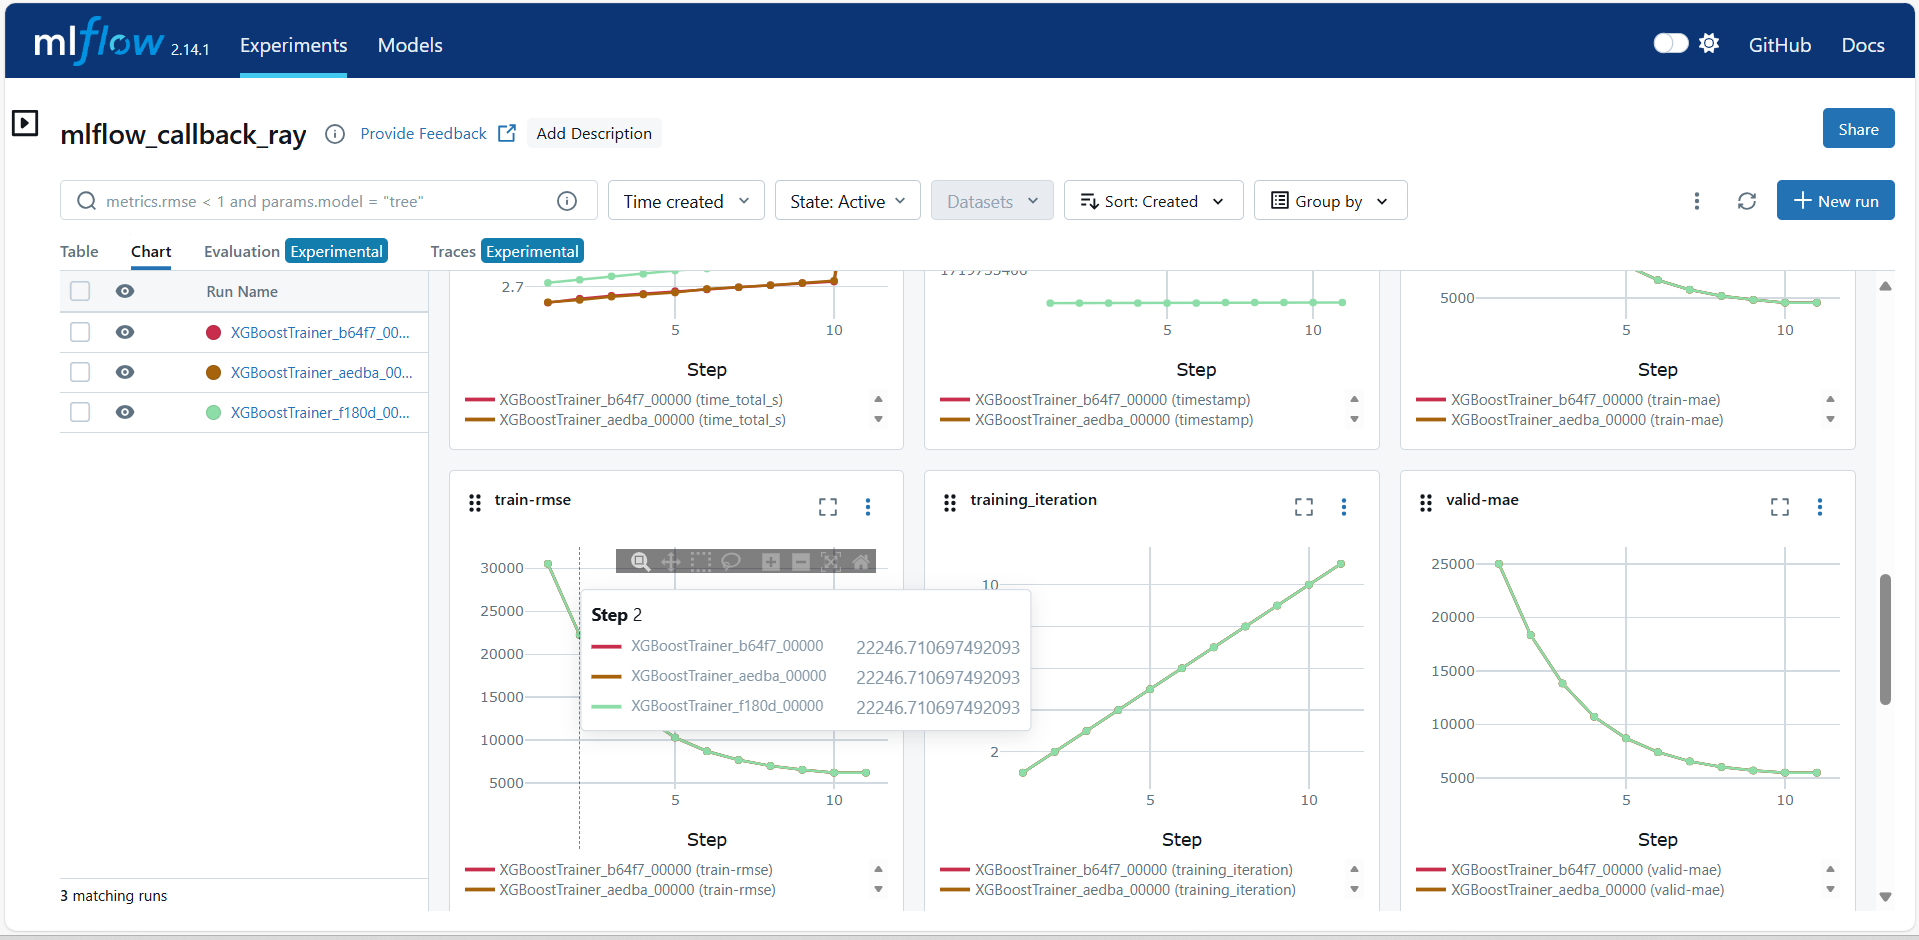

## Evaluating the metrices from MLFlow
As you can also see your own MLFlow server that the run in your experiment is working fine. The Training and Validation MAE, RMSE metrices both are decreasing gradually in the visualization. Though it may arise the problem of "overfitting", but that's a discussion of another session (you may try to reduce overfitting in this scenario too if you want to, but remember the time constraint of the lab).

As we are pleased with our model training experiment's metrices, the next step would be deploying the model to Ray Cluster with Ray Serve. Deploying the model with Ray Serve ensures that it will gets scaled when it's needed to handle huge amount of requests.

Now, to deploy the model, we need to observe how the model artifacts are stored. We need to find the model file which we have just trained and prepare the processes to deploy it on the Ray cluster with Ray serve.

## Observing the Model Artificats uploaded to the Model Store Bucket

Go to the S3 bucket in the AWS console which is being used as the Model Store where all the artificates including the model file, checkpoints and other files are stored
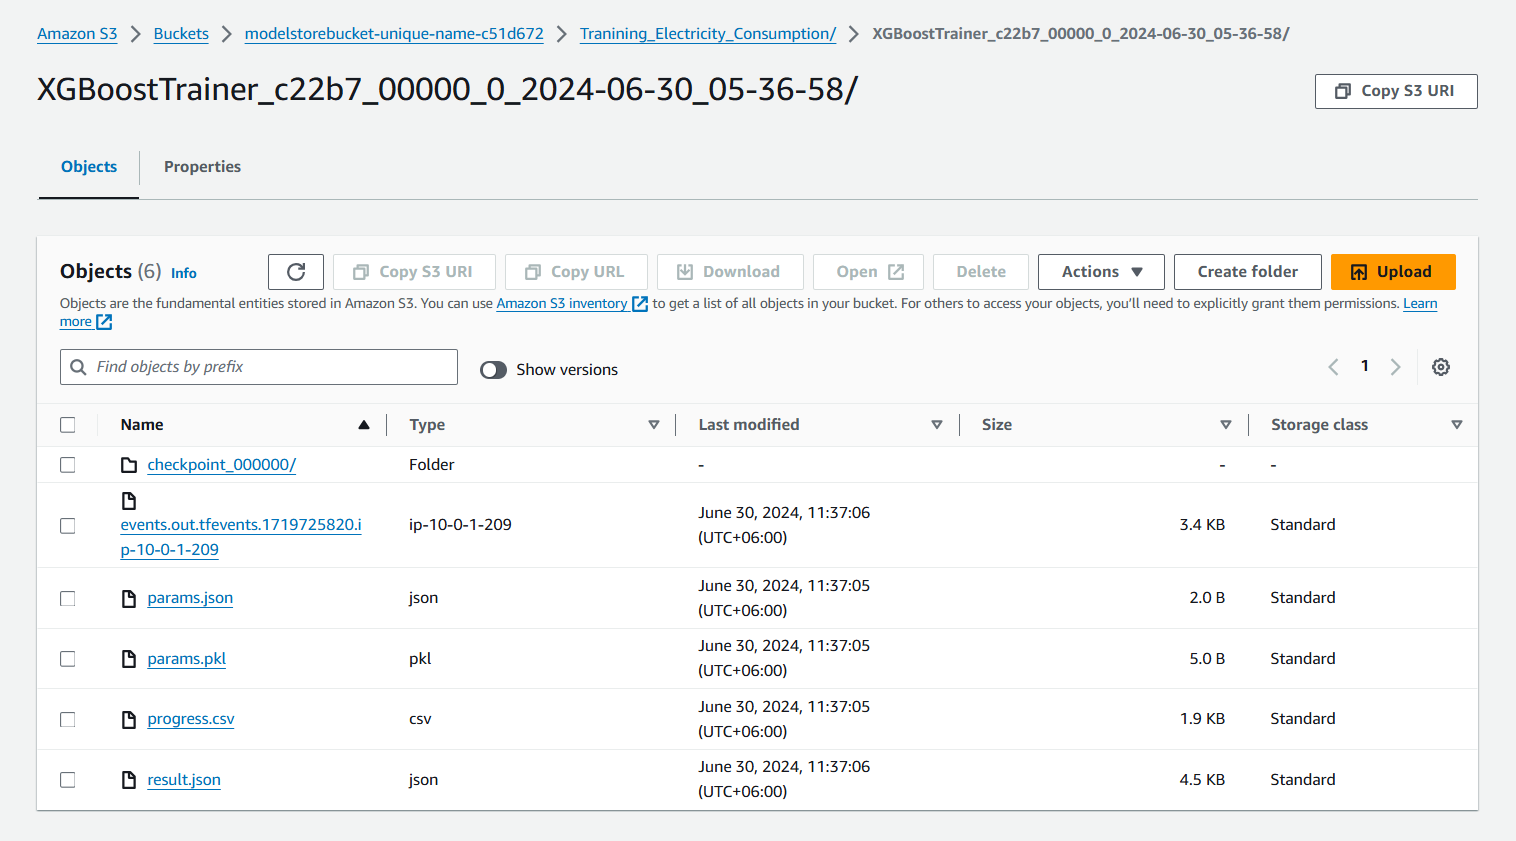

In the "checkpoint" folder, you will find the latest version of the model you have just trained.
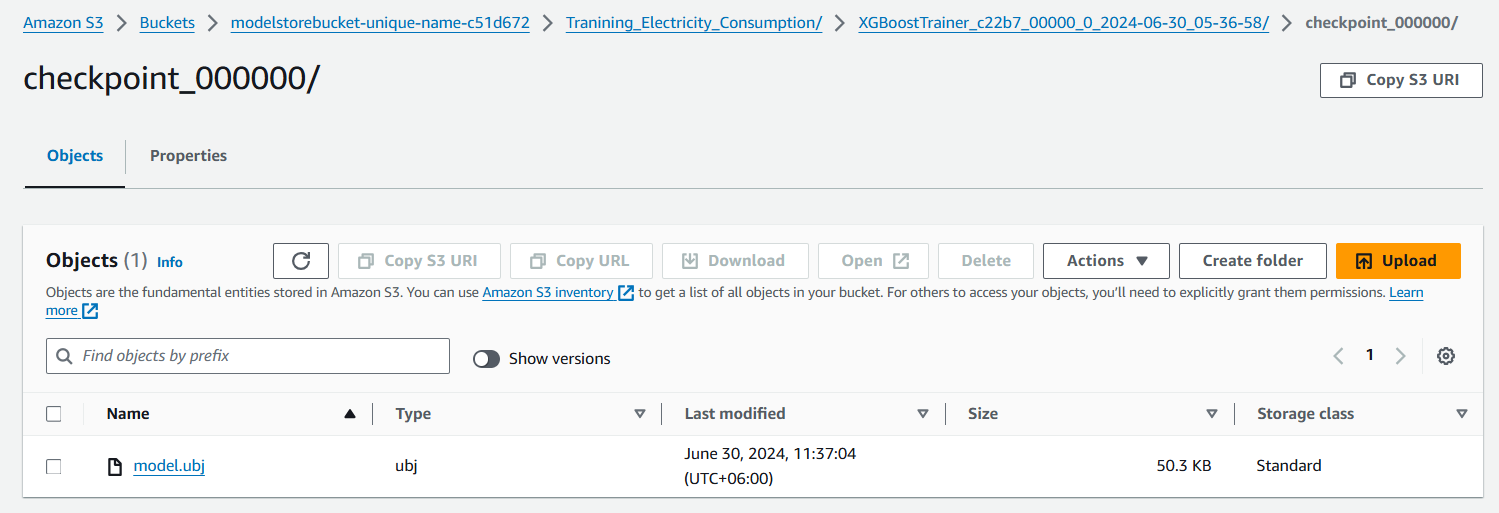

## Loading the model from latest checkpoint of Ray Trainer
You can manually load the model from the URI provided in the S3 bucket. But, in this notebook we will use the trainer.get_model() to get the latest version of the trained model.

In [12]:
model = trainer.get_model(result.checkpoint)

In [13]:
type(model)

xgboost.core.Booster

## Tracking the Model Versions
Again, we are tracking the model versions and artificats with MLFlow. We are not covering this in depth, but this is an introduction to model versioning with MLFlow./
Though, we are storing and managing the model versions manually in this notebook to show the importance of model store and feature store, and how they are built. 

In [14]:
import mlflow
import mlflow.xgboost

# Set the MLflow experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mlflow_callback_ray")


mlflow.xgboost.log_model(
    xgb_model=model,
    artifact_path="electricity-consumption-prediction",
    # signature=signature,  # Uncomment if you have a signature
    registered_model_name="xgboost-raytrain-electricity-consumption-prediction",
)

/home/ubuntu/ray_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:05:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/09/01 20:05:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'xgboost-raytrain-electricity-consumption-prediction' already exists. Creating a new version of this model...
2024/09/01 20:05:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost-raytrain-electricity-consumption-prediction, version 4
Created version '4' of model 'xgboost-raytrain-electricity-consumption-prediction'.


In [15]:
mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path="electricity-consumption-prediction",
        # signature=signature,
        registered_model_name="xgboost-raytrain-electricity-consumption-prediction",
    )

/home/ubuntu/ray_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:05:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/09/01 20:05:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'xgboost-raytrain-electricity-consumption-prediction' already exists. Creating a new version of this model...
2024/09/01 20:05:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost-raytrain-electricity-consumption-prediction, version 5
Created version '5' of model 'xgboost-raytrain-electricity-consumption-prediction'.


You will the modeled registered in the "Models" section of MLFlow,
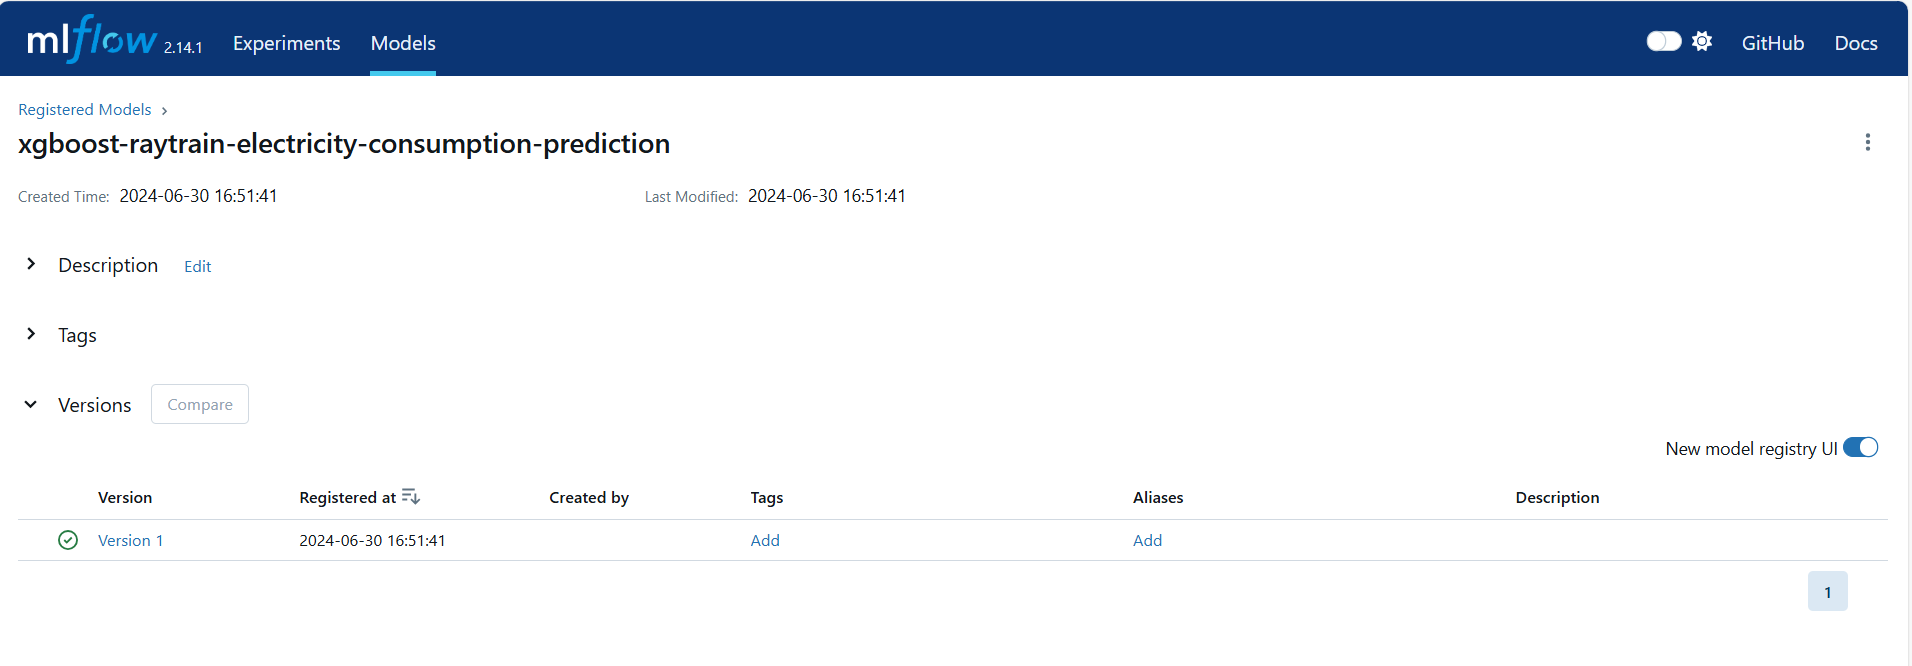

In [16]:
result.checkpoint

Checkpoint(filesystem=s3, path=modelstorebucket-poridhi-12345-f772b84/Tranining_Electricity_Consumption/XGBoostTrainer_1cd9c_00000_0_2024-09-01_20-02-27/checkpoint_000000)

#### Saving the model as a pickle file
Saving the model as a pickle file would help the deployment process. We are going to use the pickle file while deploying the model with Ray Serve

In [19]:
import pickle

with open('latest-model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [23]:
type(model_homelander)

NameError: name 'model_homelander' is not defined

# Tracking the dataset 

In [24]:
train_dataset

MaterializedDataset(
   num_blocks=1,
   num_rows=6988,
   schema={
      Year: int64,
      Month: int64,
      Day: int64,
      Hour: int64,
      Temperature_mean: float64,
      Humidity_mean: float64,
      WindSpeed_mean: float64,
      GeneralDiffuseFlows_mean: float64,
      DiffuseFlows_mean: float64,
      Weekday_first: int64,
      IsWeekend_first: int64,
      TimeOfDay_Afternoon_first: int64,
      TimeOfDay_Evening_first: int64,
      TimeOfDay_Morning_first: int64,
      TimeOfDay_Night_first: int64,
      Season_Autumn_first: int64,
      Season_Spring_first: int64,
      Season_Summer_first: int64,
      Season_Winter_first: int64,
      Temperature_mean_lag4: float64,
      Temperature_mean_lag8: float64,
      Temperature_mean_lag12: float64,
      Temperature_mean_lag24: float64,
      Temperature_mean_lag48: float64,
      Humidity_mean_lag4: float64,
      Humidity_mean_lag8: float64,
      Humidity_mean_lag12: float64,
      Humidity_mean_lag24: float64,
      

In [25]:
import mlflow
import json
import tempfile

def log_dataset_info(train_dataset, valid_dataset, experiment_name="mlflow_callback_ray"):
    # Set the MLflow experiment
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # mlflow.set_experiment("mlflow_callback_ray")
    mlflow.set_experiment(experiment_name)
    # Convert Ray datasets to pandas DataFrames to access columns and count
    train_df = train_dataset.to_pandas()
    valid_df = valid_dataset.to_pandas()
    
    # Calculate some basic statistics or prepare a sample
    train_stats = {
        'num_samples': len(train_df),
        'feature_columns': list(train_df.columns),
        # Add more statistics as needed
    }
    valid_stats = {
        'num_samples': len(valid_df),
        'feature_columns': list(valid_df.columns),
        # Add more statistics as needed
    }

    
    # Log dataset statistics as JSON artifacts
    with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".json") as tmp:
        json.dump(train_stats, tmp)
        mlflow.log_artifact(tmp.name, "train_dataset_info")
    with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".json") as tmp:
        json.dump(valid_stats, tmp)
        mlflow.log_artifact(tmp.name, "valid_dataset_info")

    # Optionally, log a sample of the dataset
    sample_file = tempfile.NamedTemporaryFile(delete=False, suffix=".csv").name
    train_df.head(100).to_csv(sample_file)  # Adjust sample size as needed
    mlflow.log_artifact(sample_file, "dataset_samples")

# Example usage
log_dataset_info(train_dataset, valid_dataset)

#### How to Model Artifacts are Stored in the Model Store Buckets on



Let's discuss more details of **Ray Train** for distributed machine learning training and how the model artifacts is stored on the S3,

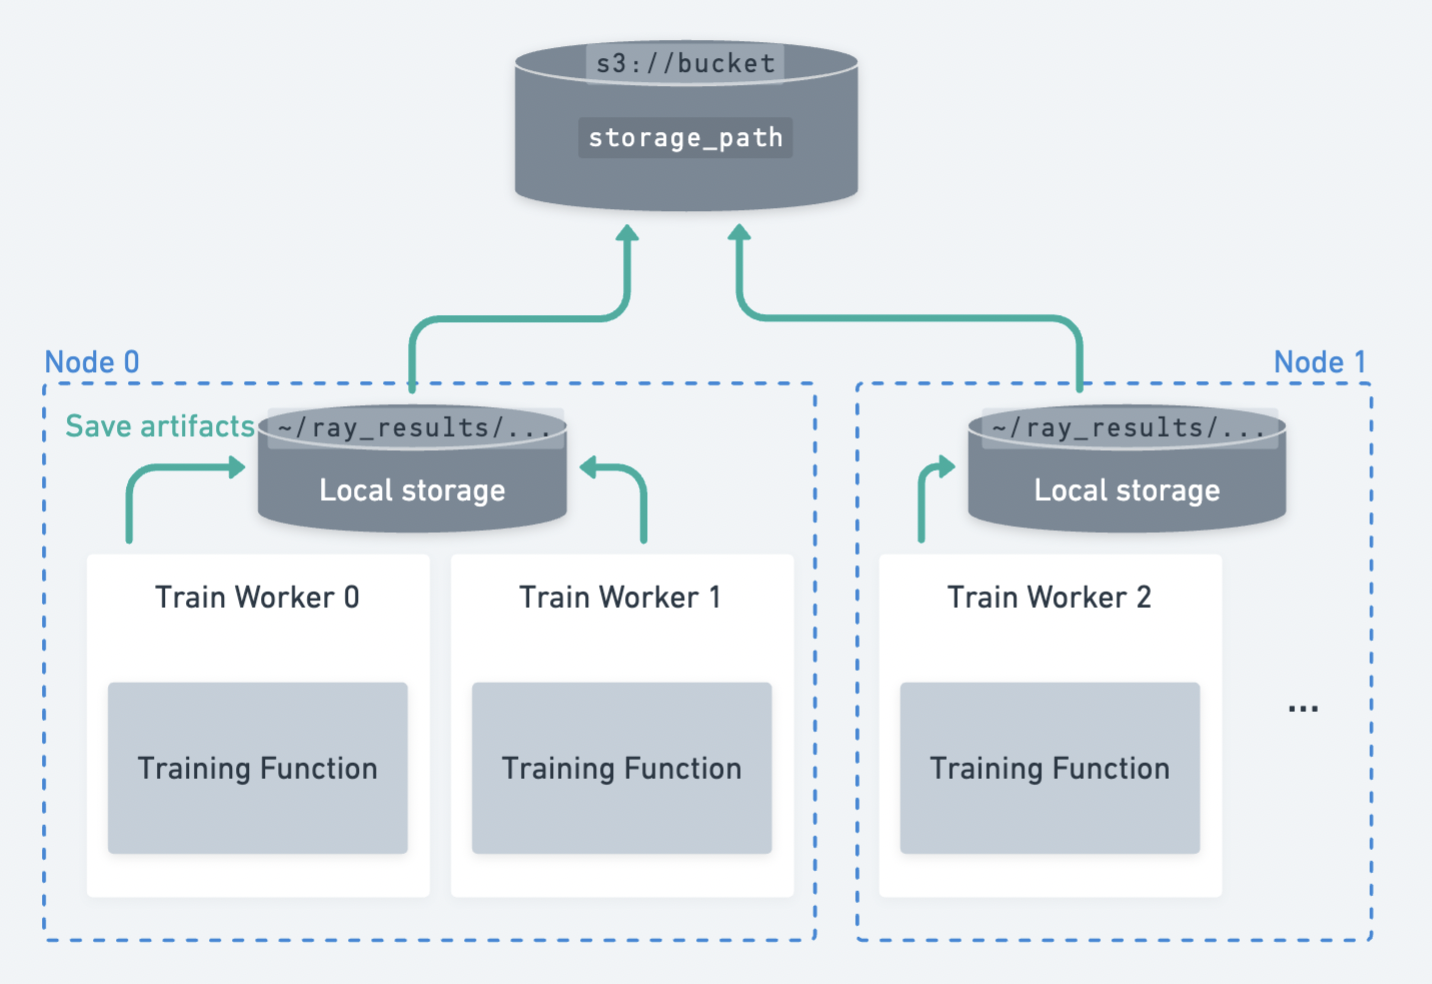

1. **Scalability and Parallelism**:
   - Ray Train enables scalable training by distributing workloads across multiple machines (nodes) in a cluster.
   - It leverages parallelism, allowing multiple training workers to process data simultaneously.
   - This architecture accelerates model training, especially for large datasets or complex models.

2. **Components**:
   - **Ray Core**: The foundational layer that manages distributed computing resources. It includes components like tasks, actors, objects, and placement groups.
   - **Ray Data**: A data processing library that integrates seamlessly with Ray Train. It handles data loading, preprocessing, and distribution across workers.
   - **Ray Train**: Specifically designed for machine learning training. It abstracts away the complexities of distributed execution, allowing developers to focus on model logic.

3. **Training Workers**:
   - Each worker (e.g., Train Worker 0, Train Worker 1) executes a training function.
   - These functions contain the actual model training code (e.g., gradient updates, loss computation).
   - Workers communicate with each other and share intermediate results.

4. **Cloud Storage and Local Storage**:
   - Cloud storage (e.g., "s3://bucket") provides a centralized location for data (e.g., datasets, model checkpoints).
   - Local storage (e.g., "/ray_results/") on each node stores temporary files, checkpoints, and other artifacts during training.

5. **Distributed Task Execution**:
   - Imagine a team of researchers working together on a complex problem.
   - Each researcher (worker) focuses on a specific aspect of the problem, collaborating to achieve the overall goal.
   - Similarly, Ray Train's workers distribute the training workload, collectively improving efficiency.

In summary, Ray Train streamlines distributed training, making it easier to harness the power of multiple machines while maintaining code simplicity. If you have further questions or need additional clarification, feel free to ask! 😊


In [26]:
# Save the trained model
result.path

'modelstorebucket-poridhi-12345-f772b84/Tranining_Electricity_Consumption/XGBoostTrainer_1cd9c_00000_0_2024-09-01_20-02-27'

In [27]:
result.checkpoint

Checkpoint(filesystem=s3, path=modelstorebucket-poridhi-12345-f772b84/Tranining_Electricity_Consumption/XGBoostTrainer_1cd9c_00000_0_2024-09-01_20-02-27/checkpoint_000000)

In [28]:
result.metrics

OrderedDict([('train-rmse', np.float64(0.03613293575239122)),
             ('train-mae', np.float64(0.02631559617802475)),
             ('valid-rmse', np.float64(0.04380443473869264)),
             ('valid-mae', np.float64(0.03086805338726232)),
             ('timestamp', 1725220961),
             ('checkpoint_dir_name', 'checkpoint_000000'),
             ('should_checkpoint', True),
             ('done', True),
             ('training_iteration', 11),
             ('trial_id', '1cd9c_00000'),
             ('date', '2024-09-01_20-02-42'),
             ('time_this_iter_s', 0.18663287162780762),
             ('time_total_s', 9.069495439529419),
             ('pid', 4848),
             ('hostname', 'workernode1'),
             ('node_ip', '10.0.1.5'),
             ('config', {}),
             ('time_since_restore', 9.069495439529419),
             ('iterations_since_restore', 11),
             ('experiment_tag', '0')])

# Sample Prediction Testing

In [29]:
import requests
import pandas as pd

# Construct the input payload
sample_request_input = {
    "Year": 2020,
    "Month": 7,
    "Day": 14,
    "Hour": 15,
    "Temperature_mean": 25.5,
    "Humidity_mean": 30,
    "WindSpeed_mean": 5,
    "GeneralDiffuseFlows_mean": 200,
    "DiffuseFlows_mean": 180,
    "Weekday_first": 1,
    "IsWeekend_first": 0,
    "TimeOfDay_Afternoon_first": 1,
    "TimeOfDay_Evening_first": 0,
    "TimeOfDay_Morning_first": 0,
    "TimeOfDay_Night_first": 0,
    "Season_Autumn_first": 0,
    "Season_Spring_first": 0,
    "Season_Summer_first": 1,
    "Season_Winter_first": 0,
    "Temperature_mean_lag4": 25.0,
    "Temperature_mean_lag8": 24.5,
    "Temperature_mean_lag12": 24.0,
    "Temperature_mean_lag24": 23.5,
    "Temperature_mean_lag48": 23.0,
    "Humidity_mean_lag4": 35,
    "Humidity_mean_lag8": 40,
    "Humidity_mean_lag12": 45,
    "Humidity_mean_lag24": 50,
    "Humidity_mean_lag48": 55,
    "WindSpeed_mean_lag4": 4,
    "WindSpeed_mean_lag8": 4.5,
    "WindSpeed_mean_lag12": 5,
    "WindSpeed_mean_lag24": 5.5,
    "WindSpeed_mean_lag48": 6,
    "GeneralDiffuseFlows_mean_lag4": 190,
    "GeneralDiffuseFlows_mean_lag8": 180,
    "GeneralDiffuseFlows_mean_lag12": 170,
    "GeneralDiffuseFlows_mean_lag24": 160,
    "GeneralDiffuseFlows_mean_lag48": 150,
    "DiffuseFlows_mean_lag4": 170,
    "DiffuseFlows_mean_lag8": 160,
    "DiffuseFlows_mean_lag12": 150,
    "DiffuseFlows_mean_lag24": 140,
    "DiffuseFlows_mean_lag48": 130,
    "PowerConsumption_Zone1_sum_lag4": 1000,
    "PowerConsumption_Zone1_sum_lag8": 1050,
    "PowerConsumption_Zone1_sum_lag12": 1100,
    "PowerConsumption_Zone1_sum_lag24": 1150,
    "PowerConsumption_Zone1_sum_lag48": 1200,
    "PowerConsumption_Zone2_sum_lag4": 2000,
    "PowerConsumption_Zone2_sum_lag8": 2050,
    "PowerConsumption_Zone2_sum_lag12": 2100,
    "PowerConsumption_Zone2_sum_lag24": 2150,
    "PowerConsumption_Zone2_sum_lag48": 2200,
    "PowerConsumption_Zone3_sum_lag4": 3000,
    "PowerConsumption_Zone3_sum_lag8": 3050,
    "PowerConsumption_Zone3_sum_lag12": 3100,
    "PowerConsumption_Zone3_sum_lag24": 3150,
    "PowerConsumption_Zone3_sum_lag48": 3200,
}
sample_df = pd.DataFrame.from_dict([sample_request_input])
sample_df.shape

(1, 59)

In [30]:
data_dmatrix = xgb.DMatrix(sample_df)
predictions = model.predict(data=data_dmatrix)


In [31]:
predictions

array([0.8681504], dtype=float32)

# Prediction Testing with the training data

In [32]:
prediction_dataframe = pd.read_csv("./3-training-data/training_features.csv")

In [33]:
prediction_dataframe = prediction_dataframe

In [34]:
prediction_dataframe_dropped = prediction_dataframe.drop(['PowerConsumption_Zone1_sum', 'PowerConsumption_Zone2_sum', 'PowerConsumption_Zone3_sum'], axis=1)

In [35]:
df_valid_features = df_valid.drop('label',axis=1)

In [36]:
data_dmatrix = xgb.DMatrix(df_valid_features)
predictions = model.predict(data=data_dmatrix)

NameError: name 'model_homelander' is not defined

In [65]:
actual_values = df_valid['label']

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_predictions(y_test, y_pred):
    """
    Visualizes the actual vs predicted values using a scatter plot and a line plot.
    Adds a diagonal line to the scatter plot to represent perfect predictions.

    Parameters:
    - y_test: The actual values.
    - y_pred: The predicted values.
    """
    # Convert to DataFrame
    df_visualization = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_visualization['Actual'], df_visualization['Predicted'], alpha=0.5)
    
    # Ideal prediction line
    min_val = min(df_visualization['Actual'].min(), df_visualization['Predicted'].min())
    max_val = max(df_visualization['Actual'].max(), df_visualization['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Diagonal line
    
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

    # Line plot for comparison
    plt.figure(figsize=(10, 6))
    plt.plot(df_visualization['Actual'].reset_index(drop=True), label='Actual Values', marker='o')
    plt.plot(df_visualization['Predicted'].reset_index(drop=True), label='Predicted Values', linestyle='--', marker='x')
    plt.title('Actual vs Predicted Values Comparison')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (assuming you have y_test and y_pred available)
# visualize_predictions(y_test, y_pred)

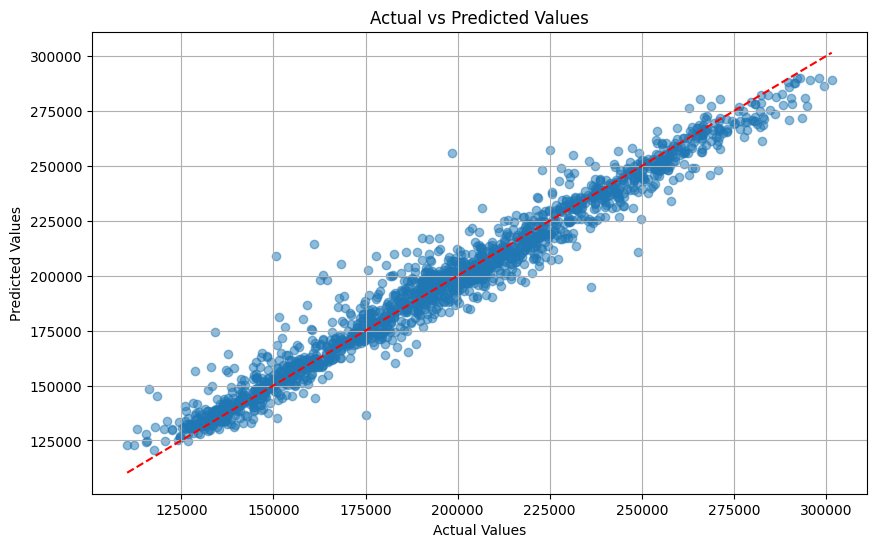

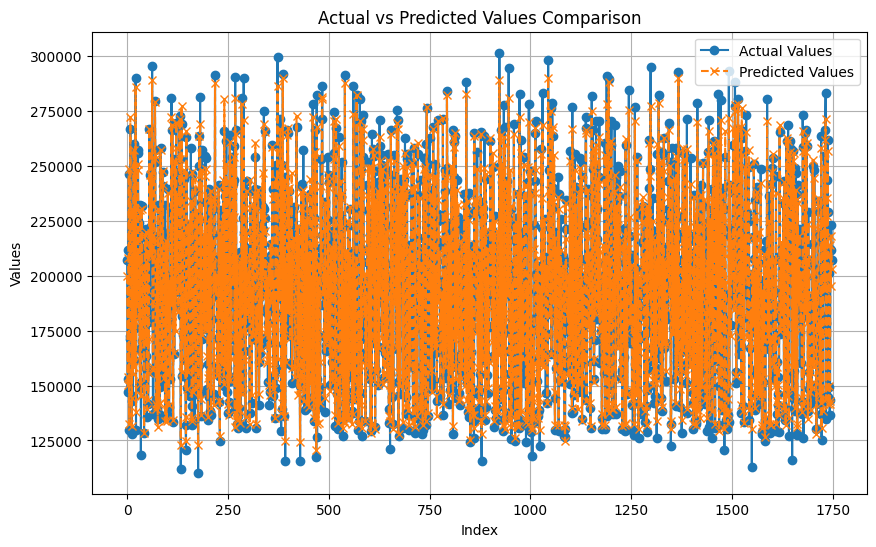

In [68]:
visualize_predictions(actual_values, predictions)